In [29]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [30]:
import numpy as np
import math
import jax
import jax.numpy as jnp
import os
import pickle
import jax
import math
from flax.training import checkpoints
import matplotlib.pyplot as plt
from utils.tools_1 import make_library_functions

from models.models_1.model_1_nl_time_lat_lon_CAE_wnl import (
    ConcreteAutoencoder,
    create_train_state,
    train_for_epochs,
)

# gpu_devices = jax.devices("gpu")
# if gpu_devices:
#     device = gpu_devices[0]
# else:
#     device = jax.devices("cpu")[0]

num_epochs = 1000
initial_lr = 5e-3
min_temp = 0.01
start_temp = 10.

# library_functions = [ "(_)**2", "(_)**3"]
library_functions = [ "(_)**2", "(_)**3", "(_)**4", "jnp.sin(_)", "jnp.cos(_)" ]
repulsion_coeff = 1e-1
library_functions = tuple(make_library_functions(library_functions))

with open("../data/u_10m_comp_vals_3.pkl", 'rb') as f:
    loaded_data = pickle.load(f)

S_train = loaded_data['train']['data']
train_times = loaded_data['train']['time']

S_test = loaded_data['test']['data']
test_times = loaded_data['test']['time']

S_val = loaded_data['val']['data']
val_times = loaded_data['val']['time']

lat_vals = loaded_data['lat_vals']
lon_vals = loaded_data['lon_vals']

r_val = loaded_data['r95']
batch_size = max(S_train.shape[1] // 256, 256)

# print(S_train.shape[1], batch_size) # 128
 
Nh_val = S_train.shape[0]
r_val = 24
p_val = 20

lon_grid, lat_grid = np.meshgrid(lon_vals, lat_vals, indexing="xy")
global_coords = np.stack([lon_grid.ravel(), lat_grid.ravel()], axis=1)  # (Nh,2)

steps_per_epoch = (S_train.shape[1] + batch_size - 1) // batch_size
alpha_const = math.exp(math.log(min_temp / start_temp) / (num_epochs * steps_per_epoch))

rng = jax.random.PRNGKey(0)
model = ConcreteAutoencoder(
    library_functions= library_functions,
    min_temp     = min_temp,
    start_temp   = start_temp,
    alpha_const  = alpha_const,
    global_coords= jnp.array(global_coords),
    enc1_inp_dim  = Nh_val,
    enc1_out_dim  = r_val,
    enc2_inp_dim  = int(r_val * len(library_functions)),
    enc2_out_dim  = p_val,
    frac_dynamics= 0.5
)


restored_state = create_train_state(
    rng,
    model,
    input_shape=(batch_size, Nh_val),
    lr=initial_lr,
)

results_dir = f'/workspace/venu_files/climate_forecasting/CAE_transf/results/wCAE_wnl_ne{num_epochs}_lib{len(library_functions)}_bs{batch_size}_lr{initial_lr}_Nval{Nh_val}_rval{r_val}_rc{repulsion_coeff}_m2/'
os.makedirs(f"{results_dir}", exist_ok=True)

CKPT_DIR = f"{results_dir}checkpoints"
os.makedirs(CKPT_DIR, exist_ok=True)

restored_state = checkpoints.restore_checkpoint(
    ckpt_dir=CKPT_DIR,
    target=restored_state       # will be replaced with the latest checkpoint
)

# results:
# 1. test data predictions comparison:

from models.models_1.model_1_nl_time_lat_lon_CAE_wnl import (
    Dff_Network,
    Decoder
)

from utils.timefeatures import time_features
import pandas as pd

with open(results_dir + "final_results.pkl", "rb") as file:
    final_results = pickle.load(file)

train_loss_hist = final_results['train_loss_hist']
val_loss_hist = final_results['val_loss_hist']
mean_max_prob_spt = final_results['mean_max_prob_spt']
logit_vals_hist_spt = final_results['logit_vals_hist_spt']

mean_max_prob_lib = final_results['mean_max_prob_lib']
logit_vals_hist_lib = final_results['logit_vals_hist_lib']

best_train_loss = final_results['best_train_loss']
best_val_loss = final_results['best_val_loss']

best_logits_spt = logit_vals_hist_spt[np.argmin(val_loss_hist)]
selected_indices_spt = jnp.argmax(best_logits_spt, axis=1)
dff_params =     restored_state.params['dff_network']
decoder_params = restored_state.params['decoder']
selected_coords = global_coords[selected_indices_spt]

print(len(logit_vals_hist_spt), len(logit_vals_hist_lib))
best_logits_lib = logit_vals_hist_lib[np.argmin(val_loss_hist)]
selected_indices_lib = jnp.argmax(best_logits_lib, axis=1)

S_test_t = S_test.T

test_times_pd = pd.to_datetime(test_times)
test_times_enc = time_features(test_times_pd, freq='h')
test_times_enc = test_times_enc.T

test_times_expanded = jnp.broadcast_to(test_times_enc[:, None, :], (S_test_t.shape[0], r_val, 4))

coords_expanded = jnp.broadcast_to(selected_coords[None, ...], (S_test_t.shape[0], r_val, 2))
test_dff_input = jnp.concatenate([test_times_expanded, coords_expanded], axis=-1)

encoder1_input_dim = Nh_val
encoder1_output_dim = r_val
dff_network_module_tester = Dff_Network(input_dim=6, output_dim=1, decoder_input_dim=p_val)

encoder2_input_dim = int(r_val * len(library_functions))
encoder2_output_dim = p_val

Decoder_module_tester = Decoder(input_dim=encoder2_output_dim, output_dim=encoder1_input_dim)

test_dff_output = dff_network_module_tester.apply({'params': dff_params}, test_dff_input, deterministic=True, mutable=False)

test_preds = Decoder_module_tester.apply({'params': decoder_params}, test_dff_output, deterministic=True, mutable=False)

S_test_pred = test_preds.T

1000 1000


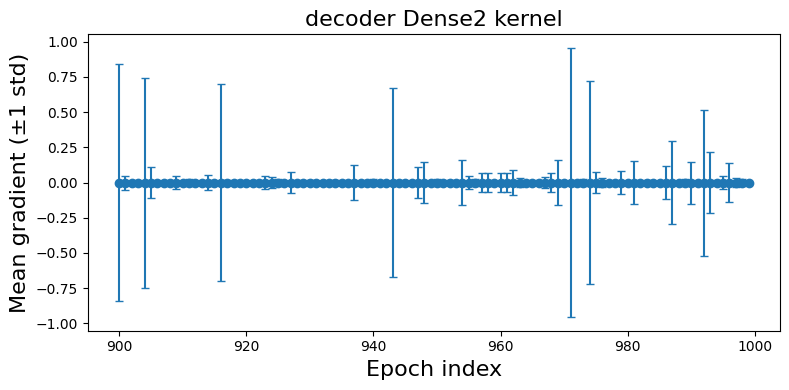

In [ ]:
preserved_grads = final_results['preserved_grads']
# print(S_test_pred.shape, S_test.shape) # (22701, 868) (22701, 868)
# print(preserved_grads[0].shape)

# print(len(preserved_grads))

# print(preserved_grads[0].item().keys()) # dict_keys(['decoder', 'dff_network', 'encoder1', 'encoder2'])
# print(preserved_grads[0].item()['decoder'].keys()) # dict_keys(['Dense_0', 'Dense_1', 'Dense_2'])
# print(preserved_grads[0].item()['decoder']['Dense_0'].keys()) # dict_keys(['bias', 'kernel'])
# print(preserved_grads[0].item()['decoder']['Dense_1'].keys()) # dict_keys(['bias', 'kernel'])
# print(preserved_grads[0].item()['decoder']['Dense_2'].keys()) # dict_keys(['bias', 'kernel'])

# print(preserved_grads[0].item()['dff_network'].keys()) # dict_keys(['Dense_0', 'Dense_1', 'Dense_2', 'Dense_3'])
# print(preserved_grads[0].item()['dff_network']['Dense_0'].keys()) # dict_keys(['bias', 'kernel'])

# print(preserved_grads[0].item()['encoder1'].keys()) # dict_keys(['logits'])
# print(preserved_grads[0].item()['encoder2'].keys()) # dict_keys(['logits'])

test_stack = []
for i in range(len(preserved_grads)):
    test_stack.append( preserved_grads[i].item()['encoder1']['logits']      )

# print(len(test_stacked), test_stacked[0].shape) # 1000 (20, 32)

means = [arr.mean() for arr in test_stack]
stds  = [arr.std()  for arr in test_stack]

all_idxs = np.arange(len(means))
sampled_idxs = all_idxs           # 0, 10, 20, …

# slice your stats to only those points
sampled_means = np.array(means)
sampled_stds  = np.array(stds)

plt.figure(figsize=(8,4))

plt.errorbar(
    sampled_idxs[-100:],
    sampled_means[-100:],
    yerr=sampled_stds[-100:],
    fmt='o',
    capsize=3
)

plt.xlabel('Epoch index', fontsize=16)
plt.ylabel('Mean gradient (±1 std)', fontsize=16)
plt.title('decoder Dense2 kernel', fontsize=16)
plt.tight_layout()
plt.show()  

# first_epoch = preserved_grads[0]
# print(first_epoch)   

4.5189324737293646e-05 : 0.3842553496360779


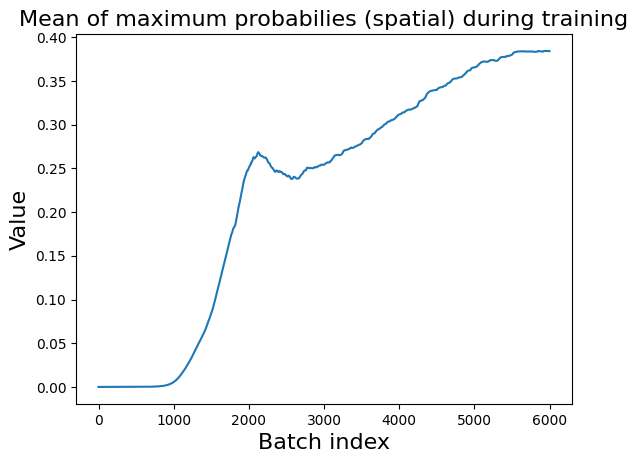

In [3]:
plt.plot(mean_max_prob_spt)
plt.xlabel('Batch index', fontsize = 16)
plt.ylabel('Value', fontsize = 16)
plt.title('Mean of maximum probabilies (spatial) during training', fontsize = 16)
plt.savefig(f'{results_dir}mean_max_prob_spatial.png')

print(np.array(mean_max_prob_spt).min(), ":", np.array(mean_max_prob_spt).max())

0.010661156848073006 : 0.16550777852535248


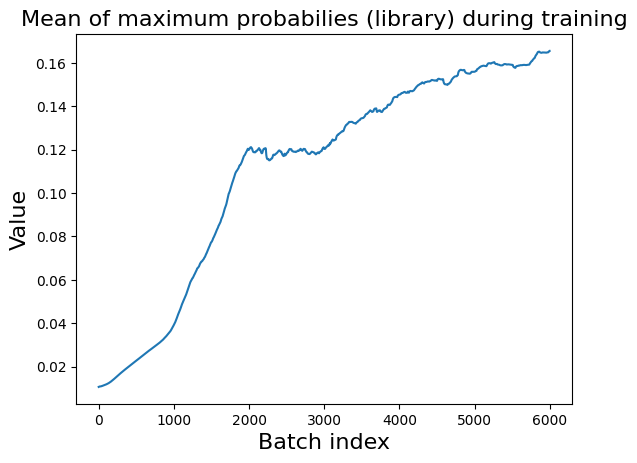

In [4]:
plt.plot(mean_max_prob_lib)
plt.xlabel('Batch index', fontsize = 16)
plt.ylabel('Value', fontsize = 16)
plt.title('Mean of maximum probabilies (library) during training', fontsize = 16)
plt.savefig(f'{results_dir}mean_max_prob_library.png')

print(np.array(mean_max_prob_lib).min(), ":", np.array(mean_max_prob_lib).max())

0.5077509 : 0.95797276


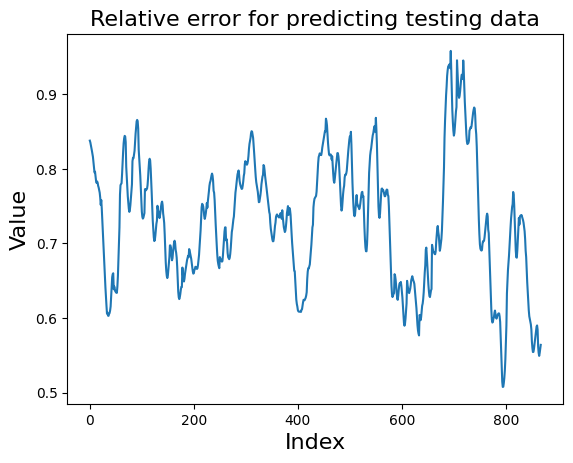

In [4]:
test_pred_errs = []
for i in range(S_test.shape[1]):
    test_pred_errs.append(np.linalg.norm(S_test[:,i] - S_test_pred[:,i])/ np.linalg.norm(S_test[:,i]))

np.save(f'{results_dir}test_pred_err_vals.npy', test_pred_errs)

plt.plot(test_pred_errs)
plt.xlabel('Index', fontsize = 16)
plt.ylabel('Value', fontsize = 16)
plt.title('Relative error for predicting testing data', fontsize = 16)
plt.savefig(f'{results_dir}test_pred_errs.png')

print(np.array(test_pred_errs).min(), ":", np.array(test_pred_errs).max())

61553.64272782137 : 7285235.0609535305
0.6603604212463626 : 2.556196328599443


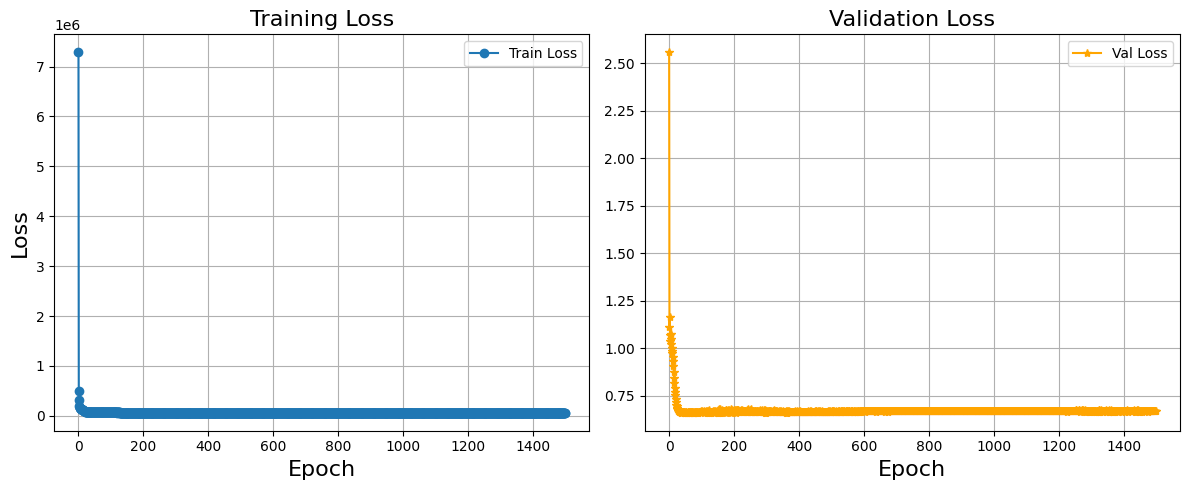

In [5]:
# 2. train and validation loss hist:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: training loss
axes[0].plot(train_loss_hist, marker='o', label='Train Loss')
axes[0].set_title('Training Loss', fontsize = 16)
axes[0].set_xlabel('Epoch', fontsize = 16)
axes[0].set_ylabel('Loss', fontsize = 16)
axes[0].grid(True)
axes[0].legend()

# Right: validation loss
axes[1].plot(val_loss_hist, marker='*', color='orange', label='Val Loss')
axes[1].set_title('Validation Loss', fontsize = 16)
axes[1].set_xlabel('Epoch', fontsize = 16)
axes[1].grid(True)
axes[1].legend()
plt.tight_layout()
plt.savefig(f'{results_dir}testing_validation_loss.png')
# plt.show()


print(np.array(train_loss_hist).min(), ':', np.array(train_loss_hist).max())
print(np.array(val_loss_hist).min(), ':', np.array(val_loss_hist).max())


In [6]:
# print(selected_indices)
# 11: 1e-3
# 14: 1e-1
# 23: 1

print(len(np.unique(selected_indices_spt)))
print(len(np.unique(selected_indices_lib)))

print(np.unique(selected_indices_spt))
print(np.unique(selected_indices_lib))



19
16
[11704 11845 11846 12422 12423 12563 12564 12705 12706 12845 12846 12847
 12987 13129 20357 20500 21494 21777 22402]
[ 5  6  8  9 11 18 20 21 23 32 33 34 36 37 43 45]


(22701, 1657)


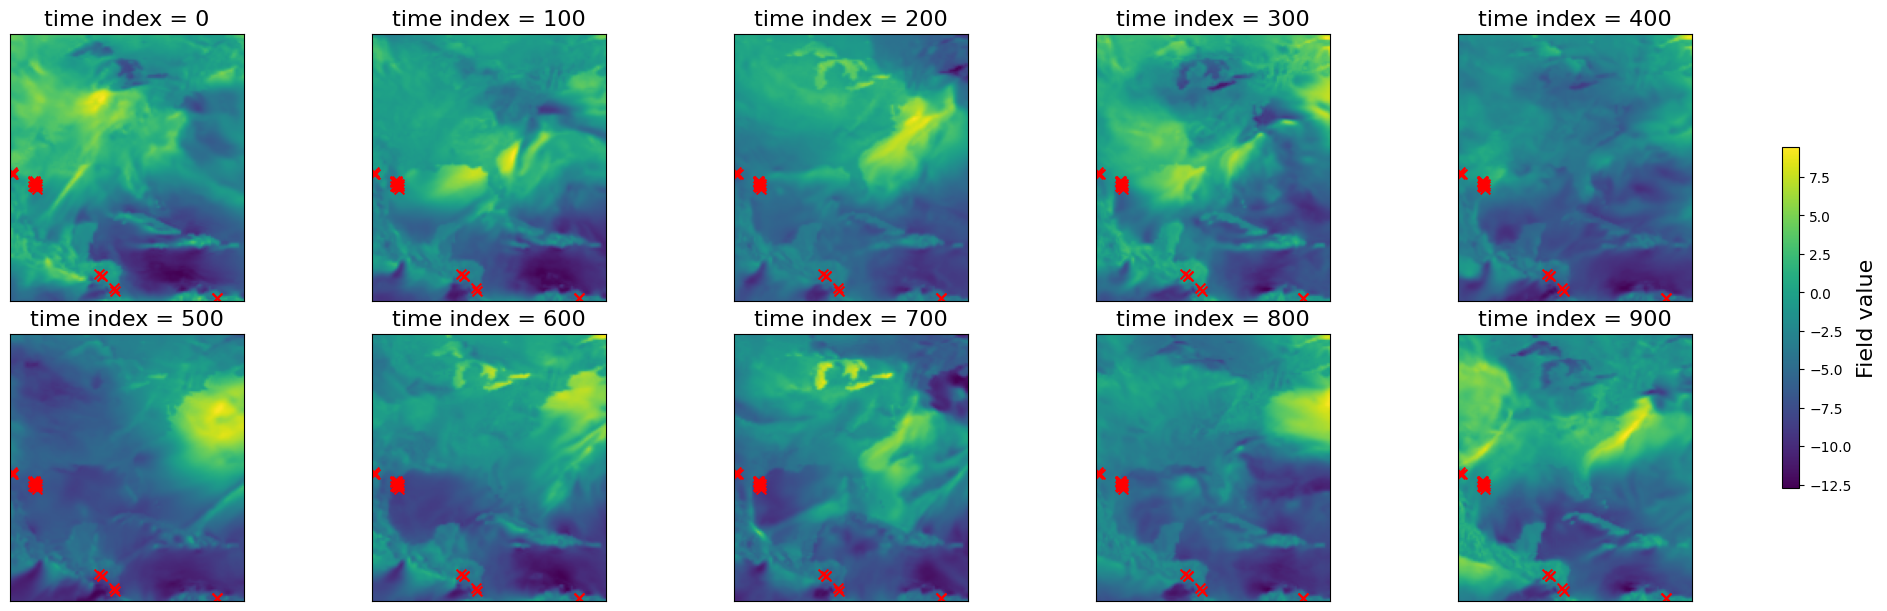

In [7]:
print(S_train.shape)
S_train_org = S_train.reshape((len(lat_vals), len(lon_vals), S_train.shape[1]))
height, width, n_time = S_train_org.shape
lon2d, lat2d = np.meshgrid(lon_vals, lat_vals)  

lon_flat = lon2d.ravel()    # shape (22701,)
lat_flat = lat2d.ravel()

# # pick out the real-world coordinates
selected_lons = lon_flat[selected_indices_spt]
selected_lats = lat_flat[selected_indices_spt]

times_to_plot = np.arange(0, 1000, 100)   # [0,100,200,…,900]
n_plots = len(times_to_plot)

# layout: e.g. 2 rows × 5 columns
ncols = 5
nrows = int(np.ceil(n_plots / ncols))

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(4*ncols, 3*nrows),
    constrained_layout=True
)

axes = axes.ravel()

for ax, t in zip(axes, times_to_plot):
    im = ax.imshow(
        S_train_org[:, :, t],
        cmap='viridis',
        origin='upper',
        extent=[
            lon_vals.min(), lon_vals.max(),
            lat_vals.min(), lat_vals.max()
        ]
    )

    ax.scatter(
    selected_lons,   
    selected_lats,   
    c='r',
    marker='x',
    s=50,
    label='selected'
    )

    ax.set_title(f"time index = {t}", fontsize = 16)
    ax.set_xticks([])
    ax.set_yticks([])

for ax in axes[n_plots:]:
    ax.axis("off")

cbar = fig.colorbar(im, ax=axes[:n_plots].tolist(), shrink=0.6)
cbar.set_label("Field value", fontsize = 16)
plt.savefig(f'{results_dir}u10m_selected_points_time_series.png')
# plt.show()

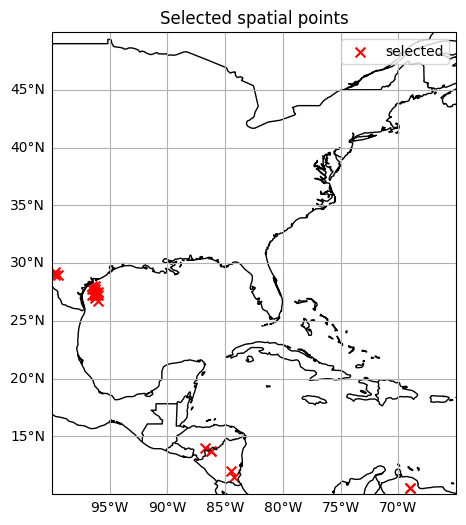

In [8]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig = plt.figure(figsize=(8, 6))

ax = plt.axes(projection=ccrs.PlateCarree())

lon_min = lon_vals.min()
lon_max = lon_vals.max()

lat_min = lat_vals.min()
lat_max = lat_vals.max()


ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE.with_scale("50m"))
ax.add_feature(cfeature.BORDERS.with_scale("50m"))

# scatter the points (specify the PlateCarree transform)
ax.scatter(
    selected_lons,
    selected_lats,
    c="red",
    marker="x",
    s=50,
    transform=ccrs.PlateCarree(),
    label="selected"
)

# add gridlines
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels = gl.right_labels = False

ax.set_title("Selected spatial points")
ax.legend(loc="upper right")
plt.savefig(f'{results_dir}u10m_selected_points_map.png')

selected_coords = {
    'selected_lons': selected_lons,
    'selected_lats': selected_lats,
}

with open(f'{results_dir}selected_coords.pkl', 'wb') as f:
    pickle.dump(selected_coords, f)

# plt.show()

In [22]:
# comparison of epoch training.

# 1. testing pred error vals.
test_dir1 = f'/workspace/venu_files/climate_forecasting/CAE_transf/results/ne1_lr{initial_lr}_Nval{Nh_val}_rval{r_val}_m2/'
test_dir10 = f'/workspace/venu_files/climate_forecasting/CAE_transf/results/ne10_lr{initial_lr}_Nval{Nh_val}_rval{r_val}_m2/'
test_dir100 = f'/workspace/venu_files/climate_forecasting/CAE_transf/results/ne100_lr{initial_lr}_Nval{Nh_val}_rval{r_val}_m2/'
test_dir1000 = f'/workspace/venu_files/climate_forecasting/CAE_transf/results/ne1000_lr{initial_lr}_Nval{Nh_val}_rval{r_val}_m2/'


with open(test_dir1 + "final_results.pkl", "rb") as file:
    final_results_1 = pickle.load(file)

train_loss_hist_1 = final_results_1['train_loss_hist']
val_loss_hist_1 =   final_results_1['val_loss_hist']
mean_max_prob_1 =   final_results_1['mean_max_prob']
logit_vals_hist_1 = final_results_1['logit_vals_hist']
best_train_loss_1 = final_results_1['best_train_loss']
best_val_loss_1 =   final_results_1['best_val_loss']

with open(test_dir10 + "final_results.pkl", "rb") as file:
    final_results_10 = pickle.load(file)

train_loss_hist_10 = final_results_10['train_loss_hist']
val_loss_hist_10 =   final_results_10['val_loss_hist']
mean_max_prob_10 =   final_results_10['mean_max_prob']
logit_vals_hist_10 = final_results_10['logit_vals_hist']
best_train_loss_10 = final_results_10['best_train_loss']
best_val_loss_10 =   final_results_10['best_val_loss']


with open(test_dir100 + "final_results.pkl", "rb") as file:
    final_results_100 = pickle.load(file)

train_loss_hist_100 = final_results_100['train_loss_hist']
val_loss_hist_100 =   final_results_100['val_loss_hist']
mean_max_prob_100 =   final_results_100['mean_max_prob']
logit_vals_hist_100 = final_results_100['logit_vals_hist']
best_train_loss_100 = final_results_100['best_train_loss']
best_val_loss_100 =   final_results_100['best_val_loss']


with open(test_dir1000 + "final_results.pkl", "rb") as file:
    final_results_1000 = pickle.load(file)

train_loss_hist_1000 = final_results_1000['train_loss_hist']
val_loss_hist_1000 =   final_results_1000['val_loss_hist']
mean_max_prob_1000 =   final_results_1000['mean_max_prob']
logit_vals_hist_1000 = final_results_1000['logit_vals_hist']
best_train_loss_1000 = final_results_1000['best_train_loss']
best_val_loss_1000 =   final_results_1000['best_val_loss']



# 2. scatter points on map with label.
# 3. mean max prob

In [23]:
# print(len(mean_max_prob_1), len(mean_max_prob_10), len(mean_max_prob_100), len(mean_max_prob_1000) ) # 61 610 3660 13115

61 610 6100 61000


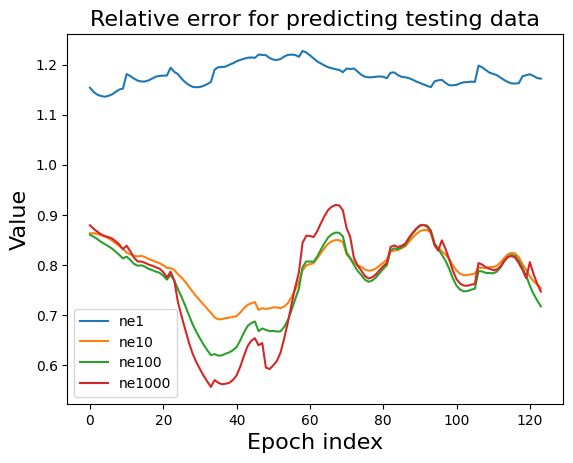

In [24]:
test_pred_errs_1 = np.load(f'{test_dir1}test_pred_err_vals.npy')
test_pred_errs_10 = np.load(f'{test_dir10}test_pred_err_vals.npy')
test_pred_errs_100 = np.load(f'{test_dir100}test_pred_err_vals.npy')
test_pred_errs_1000 = np.load(f'{test_dir1000}test_pred_err_vals.npy')

plt.plot(test_pred_errs_1, label = 'ne1')
plt.plot(test_pred_errs_10, label = 'ne10')
plt.plot(test_pred_errs_100, label = 'ne100')
plt.plot(test_pred_errs_1000, label = 'ne1000')
plt.legend()
plt.xlabel('Epoch index', fontsize = 16)
plt.ylabel('Value', fontsize = 16)
plt.title('Relative error for predicting testing data', fontsize = 16)
plt.savefig(f'{test_dir1000}test_pred_errs_comparison.png')


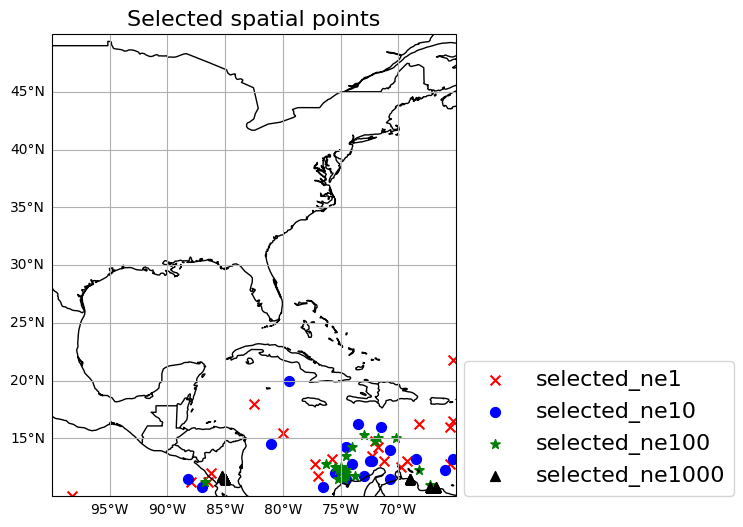

In [25]:
# selected spatial points comparison

selected_coords = {
    'selected_lons': selected_lons,
    'selected_lats': selected_lats,
}

with open(f'{test_dir1}selected_coords.pkl', 'rb') as f:
    selected_coords_1 = pickle.load(f)

with open(f'{test_dir10}selected_coords.pkl', 'rb') as f:
    selected_coords_10 = pickle.load(f)

with open(f'{test_dir100}selected_coords.pkl', 'rb') as f:
    selected_coords_100 = pickle.load(f)

with open(f'{test_dir1000}selected_coords.pkl', 'rb') as f:
    selected_coords_1000 = pickle.load(f)

selected_lons_1 = selected_coords_1['selected_lons']
selected_lats_1 = selected_coords_1['selected_lats']

selected_lons_10 = selected_coords_10['selected_lons']
selected_lats_10 = selected_coords_10['selected_lats']

selected_lons_100 = selected_coords_100['selected_lons']
selected_lats_100 = selected_coords_100['selected_lats']

selected_lons_1000 = selected_coords_1000['selected_lons']
selected_lats_1000 = selected_coords_1000['selected_lats']


fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE.with_scale("50m"))
ax.add_feature(cfeature.BORDERS.with_scale("50m"))

# scatter the points (specify the PlateCarree transform)
ax.scatter(
    selected_lons_1,
    selected_lats_1,
    c="red",
    marker="x",
    s=50,
    transform=ccrs.PlateCarree(),
    label="selected_ne1"
)

ax.scatter(
    selected_lons_10,
    selected_lats_10,
    c="blue",
    marker="o",
    s=50,
    transform=ccrs.PlateCarree(),
    label="selected_ne10"
)

ax.scatter(
    selected_lons_100,
    selected_lats_100,
    c="green",
    marker="*",
    s=50,
    transform=ccrs.PlateCarree(),
    label="selected_ne100"
)

ax.scatter(
    selected_lons_1000,
    selected_lats_1000,
    c="black",
    marker="^",
    s=50,
    transform=ccrs.PlateCarree(),
    label="selected_ne1000"
)


# add gridlines
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels = gl.right_labels = False
ax.set_title("Selected spatial points", fontsize = 16)
leg = ax.legend(loc='lower left', bbox_to_anchor=(1.02, 0.0), borderaxespad=0, fontsize = 16)
plt.subplots_adjust(right=0.78)
plt.savefig(f'{test_dir1000}u10m_selected_points_map.png')



(20, 22701)


/tmp/ipykernel_2219354/752736873.py:22: UserWarning: Adding colorbar to a different Figure <Figure size 1400x400 with 2 Axes> than <Figure size 800x600 with 1 Axes> which fig.colorbar is called on.
  cbar = fig.colorbar(im, ax=ax, orientation='horizontal', pad=0.2)


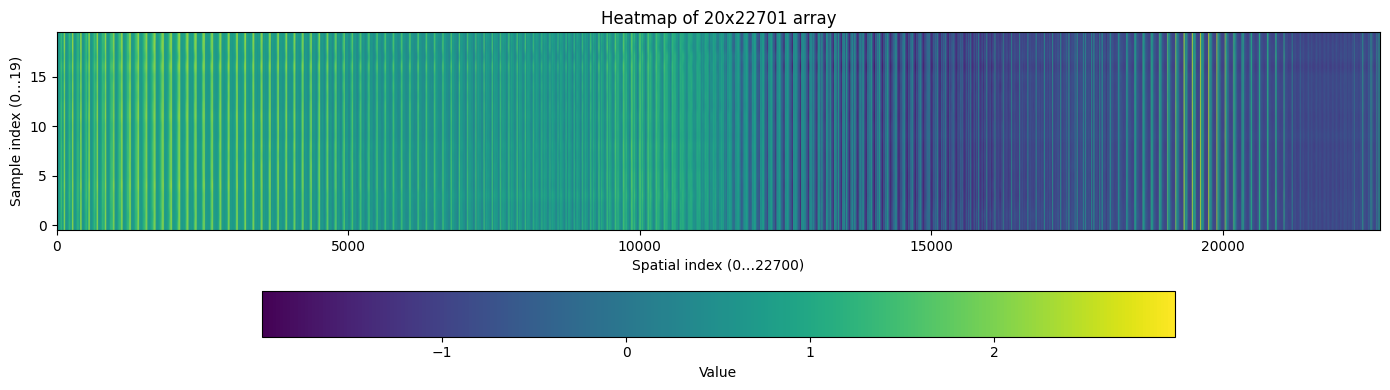

In [ ]:
# print(len(logit_vals_hist)) # 215
print(logit_vals_hist[0].shape)

arr = logit_vals_hist[0]

ig, ax = plt.subplots(figsize=(14, 4))  # wide figure for many columns

# Plot the heatmap
im = ax.imshow(
    arr,
    aspect='auto',        # lets the x‑axis span all 22701 cols
    cmap='viridis',       # or 'plasma', 'inferno', etc.
    origin='lower'        # row 0 at bottom; use 'upper' if you prefer
)

# Labels
ax.set_xlabel('Spatial index (0…22700)')
ax.set_ylabel('Sample index (0…19)')
ax.set_title('Heatmap of 20x22701 array')

# Colorbar
cbar = fig.colorbar(im, ax=ax, orientation='horizontal', pad=0.2)
cbar.set_label('Value')

plt.tight_layout()
plt.show()

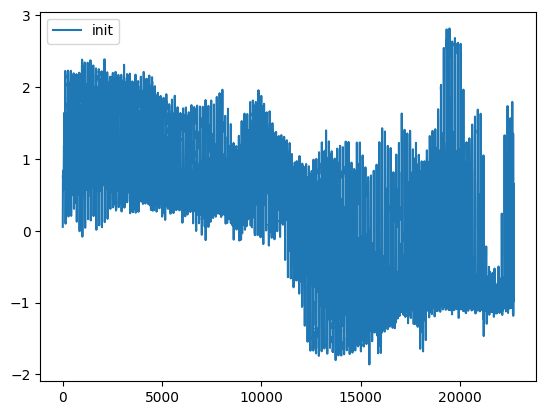

In [53]:
arr = logit_vals_hist[-1]
# arr_softmaxed = jax.nn.softmax(arr, axis = 1)

# print(logit_vals_hist[0][0].min(), ":", arr[0].max())

plt.plot(logit_vals_hist[0][5], label = 'init')
# plt.plot(logit_vals_hist[-1][5], label = 'final')
plt.legend()

# print(arr.shape) # (20, 22701)

logit_vals_softmaxed = []
for i in range(len(logit_vals_hist)):
    logit_vals_softmaxed.append(  jax.nn.softmax(logit_vals_hist[i], axis = -1)  )



In [52]:
# plt.plot(logit_vals_softmaxed[0][5], label = 'init')
# plt.plot(logit_vals_softmaxed[-1][5], label = 'final')
# plt.legend()
# print(arr.shape) # (20, 22701)


print(np.argmax(logit_vals_hist[0][5]), ":", logit_vals_hist[0][5][ np.argmax(logit_vals_hist[0][5]) ])
min_val, max_val = logit_vals_hist[0][5].min(), logit_vals_hist[0][5].max()
print(min_val, max_val)


print(np.argmax(logit_vals_softmaxed[0][5]), ":", logit_vals_softmaxed[0][5][ np.argmax(logit_vals_softmaxed[0][5]) ])
min_val, max_val = logit_vals_softmaxed[0][5].min(), logit_vals_softmaxed[0][5].max()
print(min_val, max_val)

# print(np.sum(logit_vals_softmaxed[0][5]))

print("___________________________")

print(np.argmax(logit_vals_hist[-1][5]), ":", logit_vals_hist[-1][5][ np.argmax(logit_vals_hist[-1][5]) ])
min_val, max_val = logit_vals_hist[-1][5].min(), logit_vals_hist[-1][5].max()
print(min_val, max_val)


print(np.argmax(logit_vals_softmaxed[-1][5]), ":", logit_vals_softmaxed[-1][5][ np.argmax(logit_vals_softmaxed[-1][5]) ])
min_val, max_val = logit_vals_softmaxed[-1][5].min(), logit_vals_softmaxed[-1][5].max()
print(min_val, max_val)





19468 : 2.8157275
-1.8609895 2.8157275
19468 : 0.0004001941
3.7256189e-06 0.0004001941
___________________________
18637 : 83.69263
-9.460548 83.69263
18637 : 0.9931385
3.4762e-41 0.9931385


/tmp/ipykernel_2219354/1902618802.py:19: UserWarning: Adding colorbar to a different Figure <Figure size 1400x400 with 2 Axes> than <Figure size 800x600 with 1 Axes> which fig.colorbar is called on.
  cbar = fig.colorbar(im, ax=ax, orientation='horizontal', pad=0.2)


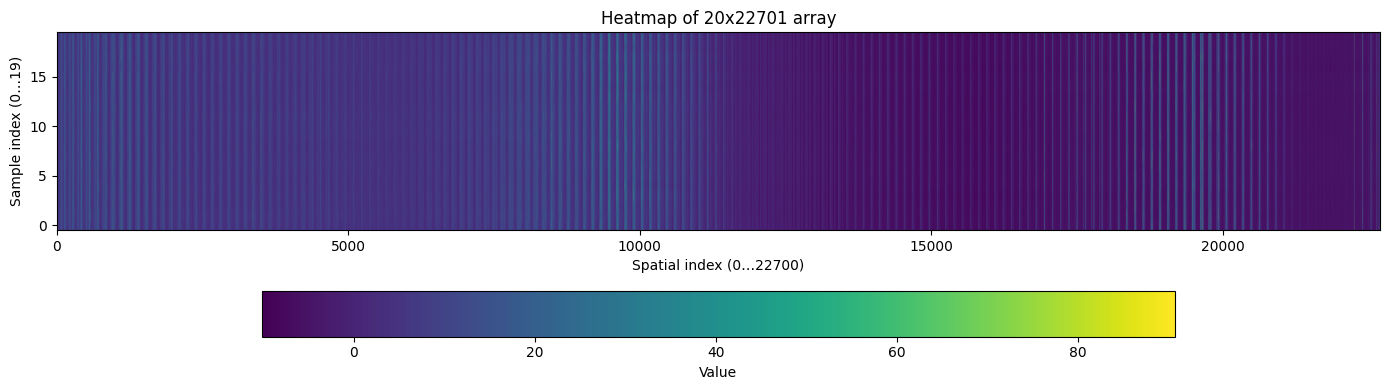

In [ ]:
# arr = logit_vals_hist[-1]

# ig, ax = plt.subplots(figsize=(14, 4))  # wide figure for many columns

# # Plot the heatmap
# im = ax.imshow(
#     arr,
#     aspect='auto',        # lets the x‑axis span all 22701 cols
#     cmap='viridis',       # or 'plasma', 'inferno', etc.
#     origin='lower'        # row 0 at bottom; use 'upper' if you prefer
# )

# # Labels
# ax.set_xlabel('Spatial index (0…22700)')
# ax.set_ylabel('Sample index (0…19)')
# ax.set_title('Heatmap of 20x22701 array')

# # Colorbar
# cbar = fig.colorbar(im, ax=ax, orientation='horizontal', pad=0.2)
# cbar.set_label('Value')

# plt.tight_layout()
# plt.show()